### Import Libraries

In [1]:
# Load, explore, process and plot data
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk

# Train Test Split
from sklearn.model_selection import train_test_split,cross_val_score

#Text Preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Machine Larning Modeling
import sklearn
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


# Deep Learning Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Embedding,SpatialDropout1D, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping


# Performance metrices
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.utils.np_utils import to_categorical


#Logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Datasets

In [2]:
data_frame_train = pd.read_csv('dataset/BBC News Train.csv')
data_frame_test = pd.read_csv('dataset/BBC News Test.csv')
print(data_frame_train.shape)
print(data_frame_test.shape)

(1490, 3)
(735, 2)


In [3]:
data_frame_train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [8]:
data_frame_test

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


In [9]:
data_frame_train.Category.unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [4]:
data_frame_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [5]:
data_frame_train['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [6]:
data_frame_train.isnull().any()

ArticleId    False
Text         False
Category     False
dtype: bool

In [7]:
category_count = data_frame_train['Category'].value_counts()
categories = category_count.index
categories

Index(['sport', 'business', 'politics', 'entertainment', 'tech'], dtype='object')

## Exploratory Data Analysis

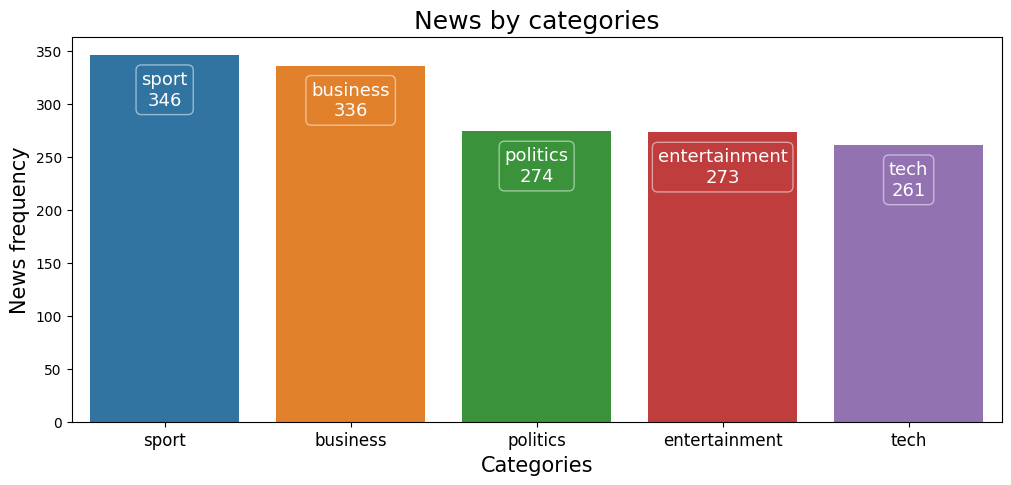

In [8]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('News frequency', size= 15)

plt.xticks(size = 12)

plt.title("News by categories" , size = 18)

plt.show()

## Text Preprocessing

In [9]:
def preprocessing(sentence):
  sentence = re.sub(r"n\'t", " not", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'s", " is", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'t", " not", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'m", " am", sentence)
  sentence = re.sub(r"wont", "will not", sentence)
  sentence = re.sub(r"wouldnt", "would not", sentence)
  sentence = re.sub(r"shouldnt", "should not", sentence)
  sentence = re.sub(r"couldnt", "could not", sentence)
  sentence = re.sub(r"cudnt", "could not", sentence)
  sentence = re.sub(r"cant", "can not", sentence)
  sentence = re.sub(r"dont", "do not", sentence)
  sentence = re.sub(r"doesnt", "does not", sentence)
  sentence = re.sub(r"didnt", "did not", sentence)
  sentence = re.sub(r"wasnt", "was not", sentence)
  sentence = re.sub(r"werent", "were not", sentence)
  sentence = re.sub(r"havent", "have not", sentence)
  sentence = re.sub(r"hadnt", "had not", sentence)
  sentence = re.sub(r"ain't", "am not",sentence)
  sentence = re.sub(r"aren't", "are not",sentence)
  sentence = re.sub(r"can't", "cannot",sentence)
  sentence = re.sub(r"can't've", "cannot have",sentence)
  sentence = re.sub(r"'cause", "because",sentence)
  sentence = re.sub(r"could've", "could have",sentence)
  sentence = re.sub(r"couldn't", "could not",sentence)
  sentence = re.sub(r"couldn't've", "could not have",sentence)
  sentence = re.sub(r"didn't", "did not",sentence)
  sentence = re.sub(r"doesn't", "does not",sentence)
  sentence = re.sub(r"don't", "do not",sentence)
  sentence = re.sub(r"hadn't", "had not",sentence)
  sentence = re.sub(r"hadn't've", "had not have",sentence)
  sentence = re.sub(r"hasn't", "has not",sentence)
  sentence = re.sub(r"haven't", "have not",sentence)
  sentence = re.sub(r"he'd", "he would",sentence)
  sentence = re.sub(r"he'd've", "he would have",sentence)
  sentence = re.sub(r"he'll", "he will",sentence)
  sentence = re.sub(r"he'll've", "he will have",sentence)
  sentence = re.sub(r"he's", "he is",sentence)
  sentence = re.sub(r"how'd", "how did",sentence)
  sentence = re.sub(r"how'd'y", "how do you",sentence)
  sentence = re.sub(r"how'll", "how will",sentence)
  sentence = re.sub(r"how's", "how is",sentence)
  sentence = re.sub(r"i'd", "I would",sentence)
  sentence = re.sub(r"i'd've", "I would have",sentence)
  sentence = re.sub(r"i'll", "I will",sentence)
  sentence = re.sub(r"i'll've", "I will have",sentence)
  sentence = re.sub(r"i'm", "I am",sentence)
  sentence = re.sub(r"i've", "I have",sentence)
  sentence = re.sub(r"isn't", "is not",sentence)
  sentence = re.sub(r"it'd", "it had",sentence)
  sentence = re.sub(r"it'd've", "it would have",sentence)
  sentence = re.sub(r"it'll", "it will",sentence)
  sentence = re.sub(r"it'll've", "it will have",sentence)
  sentence = re.sub(r"it's", "it is",sentence)
  sentence = re.sub(r"let's", "let us",sentence)
  sentence = re.sub(r"ma'am", "madam",sentence)
  sentence = re.sub(r"mayn't", "may not",sentence)
  sentence = re.sub(r"might've", "might have",sentence)
  sentence = re.sub(r"mightn't", "might not",sentence)
  sentence = re.sub(r"mightn't've", "might not have",sentence)
  sentence = re.sub(r"must've", "must have",sentence)
  sentence = re.sub(r"mustn't", "must not",sentence)
  sentence = re.sub(r"mustn't've", "must not have",sentence)
  sentence = re.sub(r"needn't", "need not",sentence)
  sentence = re.sub(r"needn't've", "need not have",sentence)
  sentence = re.sub(r"o'clock", "of the clock",sentence)
  sentence = re.sub(r"oughtn't", "ought not",sentence)
  sentence = re.sub(r"oughtn't've", "ought not have",sentence)
  sentence = re.sub(r"shan't", "shall not",sentence)
  sentence = re.sub(r"sha'n't", "shall not",sentence)
  sentence = re.sub(r"shan't've", "shall not have",sentence)
  sentence = re.sub(r"she'd", "she would",sentence)
  sentence = re.sub(r"she'd've", "she would have",sentence)
  sentence = re.sub(r"she'll", "she will",sentence)
  sentence = re.sub(r"she'll've", "she will have",sentence)
  sentence = re.sub(r"she's", "she is",sentence)
  sentence = re.sub(r"should've", "should have",sentence)
  sentence = re.sub(r"shouldn't", "should not",sentence)
  sentence = re.sub(r"shouldn't've", "should not have",sentence)
  sentence = re.sub(r"so've", "so have",sentence)
  sentence = re.sub(r"so's", "so is",sentence)
  sentence = re.sub(r"that'd", "that would",sentence)
  sentence = re.sub(r"that'd've", "that would have",sentence)
  sentence = re.sub(r"that's", "that is",sentence)
  sentence = re.sub(r"there'd", "there had",sentence)
  sentence = re.sub(r"there'd've", "there would have",sentence)
  sentence = re.sub(r"there's", "there is",sentence)
  sentence = re.sub(r"they'd", "they would",sentence)
  sentence = re.sub(r"they'd've", "they would have",sentence)
  sentence = re.sub(r"they'll", "they will",sentence)
  sentence = re.sub(r"they'll've", "they will have",sentence)
  sentence = re.sub(r"they're", "they are",sentence)
  sentence = re.sub(r"they've", "they have",sentence)
  sentence = re.sub(r"to've", "to have",sentence)
  sentence = re.sub(r"wasn't", "was not",sentence)
  sentence = re.sub(r"we'd", "we had",sentence)
  sentence = re.sub(r"we'd've", "we would have",sentence)
  sentence = re.sub(r"we'll", "we will",sentence)
  sentence = re.sub(r"we'll've", "we will have",sentence)
  sentence = re.sub(r"we're", "we are",sentence)
  sentence = re.sub(r"we've", "we have",sentence)
  sentence = re.sub(r"weren't", "were not",sentence)
  sentence = re.sub(r"what'll", "what will",sentence)
  sentence = re.sub(r"what'll've", "what will have",sentence)
  sentence = re.sub(r"what're", "what are",sentence)
  sentence = re.sub(r"what's", "what is",sentence)
  sentence = re.sub(r"what've", "what have",sentence)
  sentence = re.sub(r"when's", "when is",sentence)
  sentence = re.sub(r"when've", "when have",sentence)
  sentence = re.sub(r"where'd", "where did",sentence)
  sentence = re.sub(r"where's", "where is",sentence)
  sentence = re.sub(r"where've", "where have",sentence)
  sentence = re.sub(r"who'll", "who will",sentence)
  sentence = re.sub(r"who'll've", "who will have",sentence)
  sentence = re.sub(r"who's", "who is",sentence)
  sentence = re.sub(r"who've", "who have",sentence)
  sentence = re.sub(r"why's", "why is",sentence)
  sentence = re.sub(r"why've", "why have",sentence)
  sentence = re.sub(r"will've", "will have",sentence)
  sentence = re.sub(r"won't", "will not",sentence)
  sentence = re.sub(r"won't've", "will not have",sentence)
  sentence = re.sub(r"would've", "would have",sentence)
  sentence = re.sub(r"wouldn't", "would not",sentence)
  sentence = re.sub(r"wouldn't've", "would not have",sentence)
  sentence = re.sub(r"y'all", "you all",sentence)
  sentence = re.sub(r"y'alls", "you alls",sentence)
  sentence = re.sub(r"y'all'd", "you all would",sentence)
  sentence = re.sub(r"y'all'd've", "you all would have",sentence)
  sentence = re.sub(r"y'all're", "you all are",sentence)
  sentence = re.sub(r"y'all've", "you all have",sentence)
  sentence = re.sub(r"you'd", "you had",sentence)
  sentence = re.sub(r"you'd've", "you would have",sentence)
  sentence = re.sub(r"you'll", "you you will",sentence)
  sentence = re.sub(r"you'll've", "you you will have",sentence)
  sentence = re.sub(r"you're", "you are",sentence)
  sentence = re.sub(r"you've", "you have",sentence)

  
  sentence = re.sub(r'[^\w\s]','',sentence) # Remove Punctutation
  
  sentence = sentence.lower() # Lower case
  
  CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  sentence = re.sub(CLEANR, '', sentence)# Remove HTML
  
  sentence = re.sub('[^A-Za-z]',' ',sentence)# Remove Digits
 
  sentence = re.sub(r'[\w._%+-]{1,20}@[\w.-]{1,20}.[A-Za-z]{2,3}','', sentence)# Remove Email
  
  sentence = re.sub(r'^http?s:\/\/.*[\r\n]*','', sentence)# Remove URLs
  
  sentence = re.sub(r'@[A-Za-z0-9]+','',sentence) #Remove Mentions  

  sentence = " ".join(item for item in sentence.split() if item not in stopwords.words('english') )
  
  sentence = ' '.join([PorterStemmer().stem(word)for word in sentence.split()])

  sentence = ' '.join([WordNetLemmatizer().lemmatize(word) for word in sentence.split()])
  return sentence


In [10]:
data_frame_train['Token'] = data_frame_train.Text.apply(lambda sentence : preprocessing(sentence))

In [11]:
data_frame_train.head()

,ArticleId,Text,Category,Token
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launch defenc lawyer defend fo...
1,154,german business confidence slides german busin...,business,german busi confid slide german busi confid fe...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indic econom gloom citizen major nati...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyl govern mobil choic faster better funk...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bos payout eighteen former enron directo...


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(data_frame_train.Token,data_frame_train.Category, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1192,) (1192,)
(298,) (298,)


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
TfIdf_Vectorizer = TfidfVectorizer(tokenizer = token.tokenize)

X_train_transformed = TfIdf_Vectorizer.fit_transform(X_train)

X_test_transformed = TfIdf_Vectorizer.transform(X_test)

In [14]:
with open("TfIdf_Vectorizer.pk", "wb") as f:
    pk.dump(TfIdf_Vectorizer, f)

with open("TfIdf_Vectorizer.pk", "rb") as f:
    vector = pk.load(f)

## Convert Categorical labels into numerics

In [15]:
label_fit = LabelEncoder()
y_train_labels_fit = label_fit.fit(Y_train)
y_train_lables_trf = label_fit.transform(Y_train)
print(label_fit.classes_)

['business' 'entertainment' 'politics' 'sport' 'tech']


In [16]:
with open("label_fit.pk", "wb") as f:
    pk.dump(label_fit, f)

with open("label_fit.pk", "rb") as f:
    label_fit = pk.load(f)

**Display Output in Heat Map**

In [17]:
def plot_matrix(y_test, y_pred, color="Greens"):
    labels = np.unique(y_pred)
    cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
    sns.heatmap(cm_df, annot=True, fmt='g', cmap=color)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

In [18]:
my_tags = ['sport','business','politics','entertainment','tech']

## Naive Bayes

**Multinomial NB**

Average accuracy on test set=0.959731543624161
               precision    recall  f1-score   support

        sport       0.95      0.99      0.97        75
     business       1.00      0.96      0.98        46
     politics       0.90      0.95      0.92        56
entertainment       0.97      1.00      0.98        63
         tech       1.00      0.90      0.95        58

     accuracy                           0.96       298
    macro avg       0.96      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298



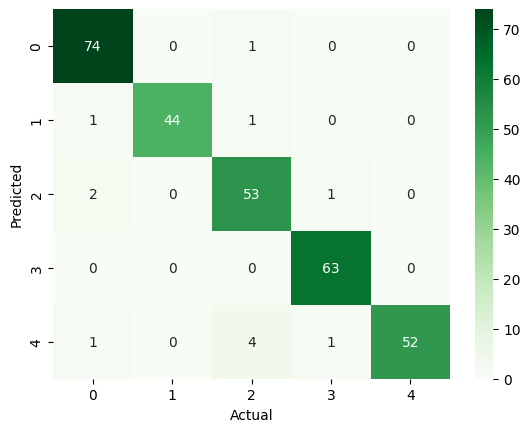

In [25]:
model_MNB = MultinomialNB()
model_MNB.fit(X_train_transformed, y_train_lables_trf)
Y_predicted_RFC = model_MNB.predict(X_test_transformed)

print('Average accuracy on test set={}'.format(np.mean(Y_predicted_RFC == label_fit.transform(Y_test))))
print(classification_report(label_fit.transform(Y_test), Y_predicted_RFC,target_names=my_tags))


plot_matrix(label_fit.transform(Y_test), Y_predicted_RFC)

**Bernoulli Naive Bayes**

Average accuracy on test set=0.9697986577181208
               precision    recall  f1-score   support

        sport       0.91      1.00      0.96        75
     business       0.98      1.00      0.99        46
     politics       0.98      0.95      0.96        56
entertainment       1.00      1.00      1.00        63
         tech       1.00      0.90      0.95        58

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



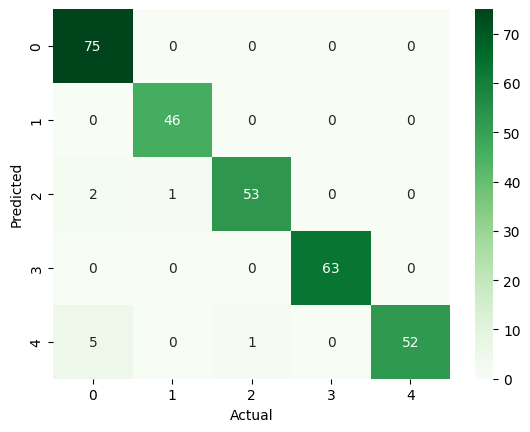

In [26]:
model_BNB = BernoulliNB()
model_BNB.fit(X_train_transformed, y_train_lables_trf)
Y_predicted_RFC = model_BNB.predict(X_test_transformed)

print('Average accuracy on test set={}'.format(np.mean(Y_predicted_RFC == label_fit.transform(Y_test))))
print(classification_report(label_fit.transform(Y_test), Y_predicted_RFC,target_names=my_tags))


plot_matrix(label_fit.transform(Y_test), Y_predicted_RFC)

**Complement Naive Beyes**

Average accuracy on test set=0.9765100671140939
               precision    recall  f1-score   support

        sport       0.97      0.97      0.97        75
     business       1.00      1.00      1.00        46
     politics       0.96      0.95      0.95        56
entertainment       0.97      1.00      0.98        63
         tech       0.98      0.97      0.97        58

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



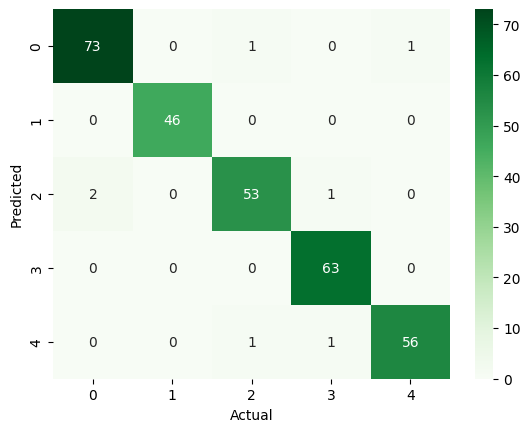

In [27]:
model_CNB = ComplementNB()
model_CNB.fit(X_train_transformed, y_train_lables_trf)
Y_predicted_RFC = model_CNB.predict(X_test_transformed)

print('Average accuracy on test set={}'.format(np.mean(Y_predicted_RFC == label_fit.transform(Y_test))))
print(classification_report(label_fit.transform(Y_test), Y_predicted_RFC,target_names=my_tags))


plot_matrix(label_fit.transform(Y_test), Y_predicted_RFC)

**K Nearest Neighbors**

Average accuracy on test set=0.9395973154362416
               precision    recall  f1-score   support

        sport       0.93      0.95      0.94        75
     business       0.96      0.93      0.95        46
     politics       0.86      0.91      0.89        56
entertainment       0.98      1.00      0.99        63
         tech       0.96      0.90      0.93        58

     accuracy                           0.94       298
    macro avg       0.94      0.94      0.94       298
 weighted avg       0.94      0.94      0.94       298



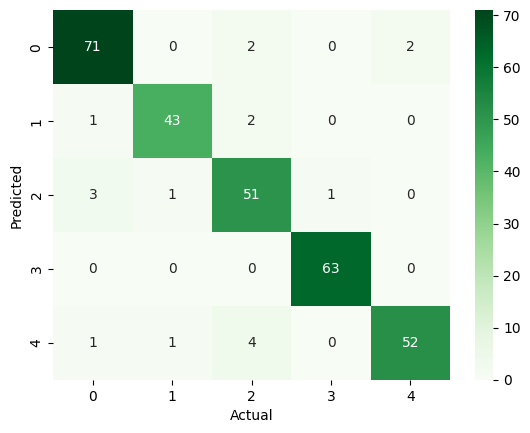

In [28]:
model_KNN = KNeighborsClassifier(n_neighbors = 5)
model_KNN.fit(X_train_transformed, y_train_lables_trf)
Y_predicted_RFC = model_KNN.predict(X_test_transformed)

print('Average accuracy on test set={}'.format(np.mean(Y_predicted_RFC == label_fit.transform(Y_test))))
print(classification_report(label_fit.transform(Y_test), Y_predicted_RFC,target_names=my_tags))


plot_matrix(label_fit.transform(Y_test), Y_predicted_RFC)

**Stochastic Gradient Descendent classifier**

Average accuracy on test set=0.9798657718120806
               precision    recall  f1-score   support

        sport       0.99      0.99      0.99        75
     business       0.98      0.98      0.98        46
     politics       0.96      0.96      0.96        56
entertainment       0.97      1.00      0.98        63
         tech       1.00      0.97      0.98        58

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



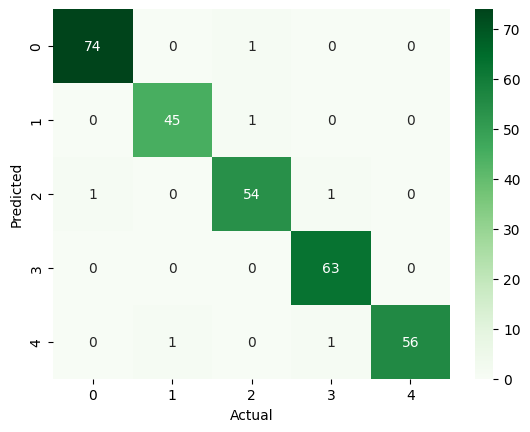

In [29]:
model_SGD = SGDClassifier()
model_SGD.fit(X_train_transformed, y_train_lables_trf)
Y_predicted_RFC = model_SGD.predict(X_test_transformed)

print('Average accuracy on test set={}'.format(np.mean(Y_predicted_RFC == label_fit.transform(Y_test))))
print(classification_report(label_fit.transform(Y_test), Y_predicted_RFC,target_names=my_tags))


plot_matrix(label_fit.transform(Y_test), Y_predicted_RFC)

**Logistic Regression**

Average accuracy on test set=0.9664429530201343
               precision    recall  f1-score   support

        sport       0.96      0.99      0.97        75
     business       0.98      0.98      0.98        46
     politics       0.95      0.95      0.95        56
entertainment       0.95      1.00      0.98        63
         tech       1.00      0.91      0.95        58

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



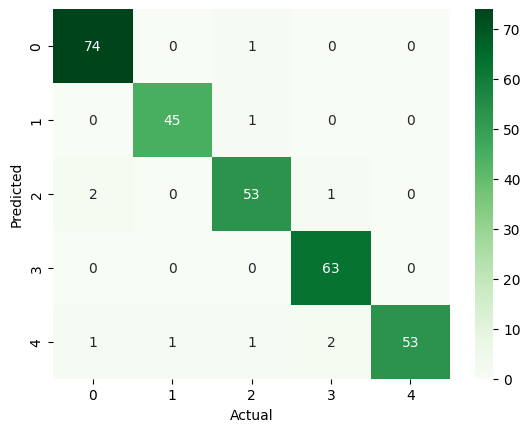

In [30]:
model_Lreg = LogisticRegression()
model_Lreg.fit(X_train_transformed, y_train_lables_trf)
Y_predicted_RFC = model_Lreg.predict(X_test_transformed)

print('Average accuracy on test set={}'.format(np.mean(Y_predicted_RFC == label_fit.transform(Y_test))))
print(classification_report(label_fit.transform(Y_test), Y_predicted_RFC,target_names=my_tags))


plot_matrix(label_fit.transform(Y_test), Y_predicted_RFC)

**Random Forest Classifier**

Average accuracy on test set=0.9496644295302014
               precision    recall  f1-score   support

        sport       0.94      0.99      0.96        75
     business       0.96      0.93      0.95        46
     politics       0.95      0.93      0.94        56
entertainment       0.93      1.00      0.96        63
         tech       1.00      0.88      0.94        58

     accuracy                           0.95       298
    macro avg       0.95      0.95      0.95       298
 weighted avg       0.95      0.95      0.95       298



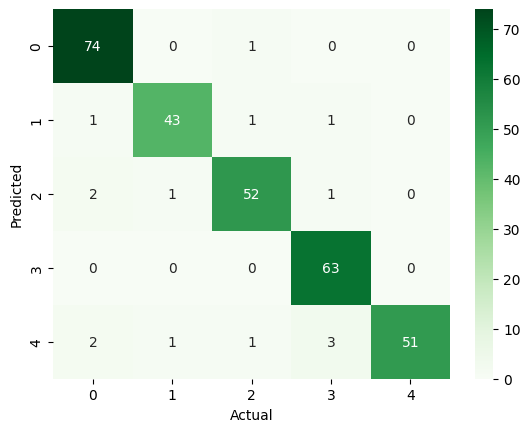

In [24]:
model_RFC = RandomForestClassifier(max_depth=10, random_state=18)
model_RFC.fit(X_train_transformed, y_train_lables_trf)
Y_predicted_RFC = model_RFC.predict(X_test_transformed)

print('Average accuracy on test set={}'.format(np.mean(Y_predicted_RFC == label_fit.transform(Y_test))))
print(classification_report(label_fit.transform(Y_test), Y_predicted_RFC,target_names=my_tags))


plot_matrix(label_fit.transform(Y_test), Y_predicted_RFC)

## ML Models pickel files

In [61]:

with open("model_BNB.pk", "wb") as f:
    pk.dump(model_BNB, f)

with open("model_CNB.pk", "wb") as f:
    pk.dump(model_CNB, f)

with open("model_MNB.pk", "wb") as f:
    pk.dump(model_MNB, f)

with open("model_RFC.pk", "wb") as f:
    pk.dump(model_RFC, f)

with open("model_SGD.pk", "wb") as f:
    pk.dump(model_SGD, f)

with open("model_Lreg.pk", "wb") as f:
    pk.dump(model_SGD, f)

with open("model_MNB.pk", "rb") as f:
    model_MNB = pk.load(f)   

with open("model_BNB.pk", "rb") as f:
    model_BNB = pk.load(f)   

with open("model_CNB.pk", "rb") as f:
    model_CNB = pk.load(f)   

with open("model_SGD.pk", "rb") as f:
    model_SGD = pk.load(f)   

with open("model_Lreg.pk", "rb") as f:
    model_Lreg = pk.load(f)   

with open("model_RFC.pk", "rb") as f:
    model_RFC = pk.load(f)   


In [33]:
article = """Harman footballer for some but an emotion for many completed football by winning the FIFA World Cup title which"""

In [72]:
def detect_catagory(model,sentence):
  sentence = re.sub(r"n\'t", " not", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'s", " is", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'t", " not", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'m", " am", sentence)
  sentence = re.sub(r"wont", "will not", sentence)
  sentence = re.sub(r"wouldnt", "would not", sentence)
  sentence = re.sub(r"shouldnt", "should not", sentence)
  sentence = re.sub(r"couldnt", "could not", sentence)
  sentence = re.sub(r"cudnt", "could not", sentence)
  sentence = re.sub(r"cant", "can not", sentence)
  sentence = re.sub(r"dont", "do not", sentence)
  sentence = re.sub(r"doesnt", "does not", sentence)
  sentence = re.sub(r"didnt", "did not", sentence)
  sentence = re.sub(r"wasnt", "was not", sentence)
  sentence = re.sub(r"werent", "were not", sentence)
  sentence = re.sub(r"havent", "have not", sentence)
  sentence = re.sub(r"hadnt", "had not", sentence)
  sentence = re.sub(r"ain't", "am not",sentence)
  sentence = re.sub(r"aren't", "are not",sentence)
  sentence = re.sub(r"can't", "cannot",sentence)
  sentence = re.sub(r"can't've", "cannot have",sentence)
  sentence = re.sub(r"'cause", "because",sentence)
  sentence = re.sub(r"could've", "could have",sentence)
  sentence = re.sub(r"couldn't", "could not",sentence)
  sentence = re.sub(r"couldn't've", "could not have",sentence)
  sentence = re.sub(r"didn't", "did not",sentence)
  sentence = re.sub(r"doesn't", "does not",sentence)
  sentence = re.sub(r"don't", "do not",sentence)
  sentence = re.sub(r"hadn't", "had not",sentence)
  sentence = re.sub(r"hadn't've", "had not have",sentence)
  sentence = re.sub(r"hasn't", "has not",sentence)
  sentence = re.sub(r"haven't", "have not",sentence)
  sentence = re.sub(r"he'd", "he would",sentence)
  sentence = re.sub(r"he'd've", "he would have",sentence)
  sentence = re.sub(r"he'll", "he will",sentence)
  sentence = re.sub(r"he'll've", "he will have",sentence)
  sentence = re.sub(r"he's", "he is",sentence)
  sentence = re.sub(r"how'd", "how did",sentence)
  sentence = re.sub(r"how'd'y", "how do you",sentence)
  sentence = re.sub(r"how'll", "how will",sentence)
  sentence = re.sub(r"how's", "how is",sentence)
  sentence = re.sub(r"i'd", "I would",sentence)
  sentence = re.sub(r"i'd've", "I would have",sentence)
  sentence = re.sub(r"i'll", "I will",sentence)
  sentence = re.sub(r"i'll've", "I will have",sentence)
  sentence = re.sub(r"i'm", "I am",sentence)
  sentence = re.sub(r"i've", "I have",sentence)
  sentence = re.sub(r"isn't", "is not",sentence)
  sentence = re.sub(r"it'd", "it had",sentence)
  sentence = re.sub(r"it'd've", "it would have",sentence)
  sentence = re.sub(r"it'll", "it will",sentence)
  sentence = re.sub(r"it'll've", "it will have",sentence)
  sentence = re.sub(r"it's", "it is",sentence)
  sentence = re.sub(r"let's", "let us",sentence)
  sentence = re.sub(r"ma'am", "madam",sentence)
  sentence = re.sub(r"mayn't", "may not",sentence)
  sentence = re.sub(r"might've", "might have",sentence)
  sentence = re.sub(r"mightn't", "might not",sentence)
  sentence = re.sub(r"mightn't've", "might not have",sentence)
  sentence = re.sub(r"must've", "must have",sentence)
  sentence = re.sub(r"mustn't", "must not",sentence)
  sentence = re.sub(r"mustn't've", "must not have",sentence)
  sentence = re.sub(r"needn't", "need not",sentence)
  sentence = re.sub(r"needn't've", "need not have",sentence)
  sentence = re.sub(r"o'clock", "of the clock",sentence)
  sentence = re.sub(r"oughtn't", "ought not",sentence)
  sentence = re.sub(r"oughtn't've", "ought not have",sentence)
  sentence = re.sub(r"shan't", "shall not",sentence)
  sentence = re.sub(r"sha'n't", "shall not",sentence)
  sentence = re.sub(r"shan't've", "shall not have",sentence)
  sentence = re.sub(r"she'd", "she would",sentence)
  sentence = re.sub(r"she'd've", "she would have",sentence)
  sentence = re.sub(r"she'll", "she will",sentence)
  sentence = re.sub(r"she'll've", "she will have",sentence)
  sentence = re.sub(r"she's", "she is",sentence)
  sentence = re.sub(r"should've", "should have",sentence)
  sentence = re.sub(r"shouldn't", "should not",sentence)
  sentence = re.sub(r"shouldn't've", "should not have",sentence)
  sentence = re.sub(r"so've", "so have",sentence)
  sentence = re.sub(r"so's", "so is",sentence)
  sentence = re.sub(r"that'd", "that would",sentence)
  sentence = re.sub(r"that'd've", "that would have",sentence)
  sentence = re.sub(r"that's", "that is",sentence)
  sentence = re.sub(r"there'd", "there had",sentence)
  sentence = re.sub(r"there'd've", "there would have",sentence)
  sentence = re.sub(r"there's", "there is",sentence)
  sentence = re.sub(r"they'd", "they would",sentence)
  sentence = re.sub(r"they'd've", "they would have",sentence)
  sentence = re.sub(r"they'll", "they will",sentence)
  sentence = re.sub(r"they'll've", "they will have",sentence)
  sentence = re.sub(r"they're", "they are",sentence)
  sentence = re.sub(r"they've", "they have",sentence)
  sentence = re.sub(r"to've", "to have",sentence)
  sentence = re.sub(r"wasn't", "was not",sentence)
  sentence = re.sub(r"we'd", "we had",sentence)
  sentence = re.sub(r"we'd've", "we would have",sentence)
  sentence = re.sub(r"we'll", "we will",sentence)
  sentence = re.sub(r"we'll've", "we will have",sentence)
  sentence = re.sub(r"we're", "we are",sentence)
  sentence = re.sub(r"we've", "we have",sentence)
  sentence = re.sub(r"weren't", "were not",sentence)
  sentence = re.sub(r"what'll", "what will",sentence)
  sentence = re.sub(r"what'll've", "what will have",sentence)
  sentence = re.sub(r"what're", "what are",sentence)
  sentence = re.sub(r"what's", "what is",sentence)
  sentence = re.sub(r"what've", "what have",sentence)
  sentence = re.sub(r"when's", "when is",sentence)
  sentence = re.sub(r"when've", "when have",sentence)
  sentence = re.sub(r"where'd", "where did",sentence)
  sentence = re.sub(r"where's", "where is",sentence)
  sentence = re.sub(r"where've", "where have",sentence)
  sentence = re.sub(r"who'll", "who will",sentence)
  sentence = re.sub(r"who'll've", "who will have",sentence)
  sentence = re.sub(r"who's", "who is",sentence)
  sentence = re.sub(r"who've", "who have",sentence)
  sentence = re.sub(r"why's", "why is",sentence)
  sentence = re.sub(r"why've", "why have",sentence)
  sentence = re.sub(r"will've", "will have",sentence)
  sentence = re.sub(r"won't", "will not",sentence)
  sentence = re.sub(r"won't've", "will not have",sentence)
  sentence = re.sub(r"would've", "would have",sentence)
  sentence = re.sub(r"wouldn't", "would not",sentence)
  sentence = re.sub(r"wouldn't've", "would not have",sentence)
  sentence = re.sub(r"y'all", "you all",sentence)
  sentence = re.sub(r"y'alls", "you alls",sentence)
  sentence = re.sub(r"y'all'd", "you all would",sentence)
  sentence = re.sub(r"y'all'd've", "you all would have",sentence)
  sentence = re.sub(r"y'all're", "you all are",sentence)
  sentence = re.sub(r"y'all've", "you all have",sentence)
  sentence = re.sub(r"you'd", "you had",sentence)
  sentence = re.sub(r"you'd've", "you would have",sentence)
  sentence = re.sub(r"you'll", "you you will",sentence)
  sentence = re.sub(r"you'll've", "you you will have",sentence)
  sentence = re.sub(r"you're", "you are",sentence)
  sentence = re.sub(r"you've", "you have",sentence)

  
  sentence = re.sub(r'[^\w\s]','',sentence) # Remove Punctutation
  
  sentence = sentence.lower() # Lower case
  
  CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  sentence = re.sub(CLEANR, '', sentence)# Remove HTML
  
  sentence = re.sub('[^A-Za-z]',' ',sentence)# Remove Digits
 
  sentence = re.sub(r'[\w._%+-]{1,20}@[\w.-]{1,20}.[A-Za-z]{2,3}','', sentence)# Remove Email
  
  sentence = re.sub(r'^http?s:\/\/.*[\r\n]*','', sentence)# Remove URLs
  
  sentence = re.sub(r'@[A-Za-z0-9]+','',sentence) #Remove Mentions  

  sentence = " ".join(item for item in sentence.split() if item not in stopwords.words('english') )
  
  sentence = ' '.join([PorterStemmer().stem(word)for word in sentence.split()])

  sentence = ' '.join([WordNetLemmatizer().lemmatize(word) for word in sentence.split()])
  sentence = list(sentence.split(" "))
  p_tfidf = vector.transform(sentence)
  result = label_fit.inverse_transform(model.predict(p_tfidf))[0]
  probability_score = model.predict_proba(p_tfidf)
  new_list = [max(probability_score[i]) for i in range(5)]
  import pandas

  return result, new_list,pandas.DataFrame(model.predict_proba(p_tfidf)*100, columns=label_fit.classes_)

In [73]:
detect_catagory(model_RFC,article)

('sport',
 [0.28191857742961274,
  0.29583815268114266,
  0.28191857742961274,
  0.28123341434289834,
  0.28191857742961274],
      business  entertainment   politics      sport       tech
 0   21.617727      21.296727  15.497651  28.191858  13.396037
 1   21.323279      20.886497  15.181151  29.583815  13.025257
 2   21.617727      21.296727  15.497651  28.191858  13.396037
 3   21.490917      21.173437  15.724759  28.123341  13.487545
 4   21.617727      21.296727  15.497651  28.191858  13.396037
 5   21.323279      20.886497  15.181151  29.583815  13.025257
 6   21.005922      21.191797  15.166145  29.625293  13.010843
 7   21.617727      21.296727  15.497651  28.191858  13.396037
 8   21.617727      21.296727  15.497651  28.191858  13.396037
 9   20.806596      20.366927  14.830293  31.379267  12.616917
 10  21.019142      20.749668  14.993458  30.255055  12.982676)

## Deep Learning Prerequisite

**Hyperparameter Tuning**

In [44]:
EMBEDDING_DIMENSION = 100
VOCABULARY_SIZE = 10000
MAX_LENGTH = 1000
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'pre'
PADDING_TYPE = 'pre'

tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True,oov_token=OOV_TOK)
tokenizer.fit_on_texts(data_frame_train['Token'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17801 unique tokens.


**Pad Sequence**

In [45]:
X = tokenizer.texts_to_sequences(data_frame_train['Token'].values)
pad_sequence_X = pad_sequences(X, maxlen=MAX_LENGTH,padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
print('Shape of data tensor:', pad_sequence_X.shape)

Shape of data tensor: (1490, 1000)


**Tokenization pickle file**

In [46]:
with open("pad_sequence_X.pk", "wb") as f:
    pk.dump(pad_sequence_X, f)


with open("pad_sequence_X.pk", "rb") as f:
    pad_sequence_X = pk.load(f)

**Conversion of label category into numbers**

In [47]:
Y = pd.get_dummies(data_frame_train['Category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1490, 5)


**Train Test Split**

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(pad_sequence_X, Y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1192, 1000)
(298, 1000)
(1192, 5)
(298, 5)


## LSTM Model

In [49]:
n_lstm = 128
drop_lstm = 0.2

In [50]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIMENSION, input_length=pad_sequence_X.shape[1]))
model_LSTM.add(SpatialDropout1D(drop_lstm))
model_LSTM.add(LSTM(n_lstm,return_sequences=False,  dropout=0.2, recurrent_dropout=0.2))
model_LSTM.add(Dropout(drop_lstm))
model_LSTM.add(Dense(5, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode = min, patience=3, min_delta=0.0001)

2023-01-04 13:46:20,391 : WARNING : EarlyStopping mode <built-in function min> is unknown, fallback to auto mode.


In [51]:
from tensorflow.keras.utils import plot_model
print(model_LSTM.summary())
plot_model(model_LSTM, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         1000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 1,117,893
Trainable params: 1,117,893
Non-trainable params: 0
______________________________________________

In [52]:
history = model_LSTM.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=10, batch_size=64,validation_split=0.1,callbacks=[es])

Epoch 1/10
19/19 [==============================] - 1151s 60s/step - loss: 1.5966 - accuracy: 0.2584 - val_loss: 1.5680 - val_accuracy: 0.3121
Epoch 2/10
19/19 [==============================] - 631s 32s/step - loss: 1.4673 - accuracy: 0.4765 - val_loss: 1.4580 - val_accuracy: 0.6275
Epoch 3/10
19/19 [==============================] - 488s 26s/step - loss: 1.2231 - accuracy: 0.8087 - val_loss: 1.1535 - val_accuracy: 0.3993
Epoch 4/10
19/19 [==============================] - 429s 22s/step - loss: 0.6823 - accuracy: 0.7819 - val_loss: 0.6932 - val_accuracy: 0.7483
Epoch 5/10
19/19 [==============================] - 385s 20s/step - loss: 0.2623 - accuracy: 0.9463 - val_loss: 0.3290 - val_accuracy: 0.8826
Epoch 6/10
19/19 [==============================] - 391s 21s/step - loss: 0.2692 - accuracy: 0.9396 - val_loss: 0.4352 - val_accuracy: 0.8792
Epoch 7/10
19/19 [==============================] - 397s 21s/step - loss: 0.1028 - accuracy: 0.9950 - val_loss: 0.1940 - val_accuracy: 0.9497
Epoch

In [53]:
score = model_LSTM.evaluate(X_test, Y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14109626412391663
Test accuracy: 0.9496644139289856


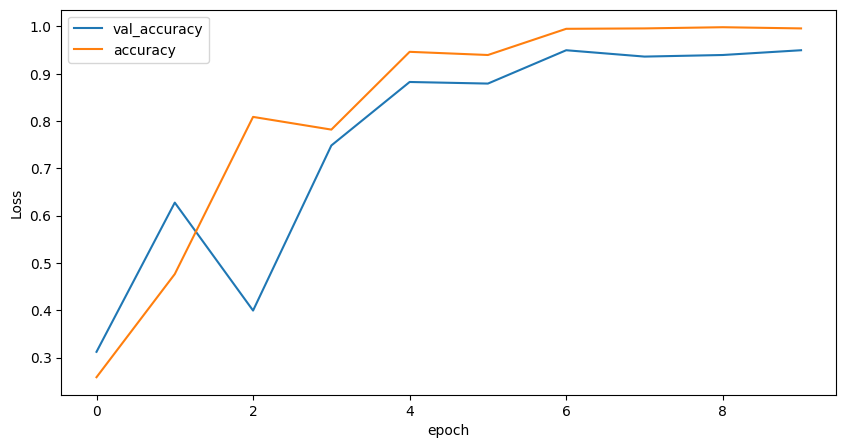

In [54]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

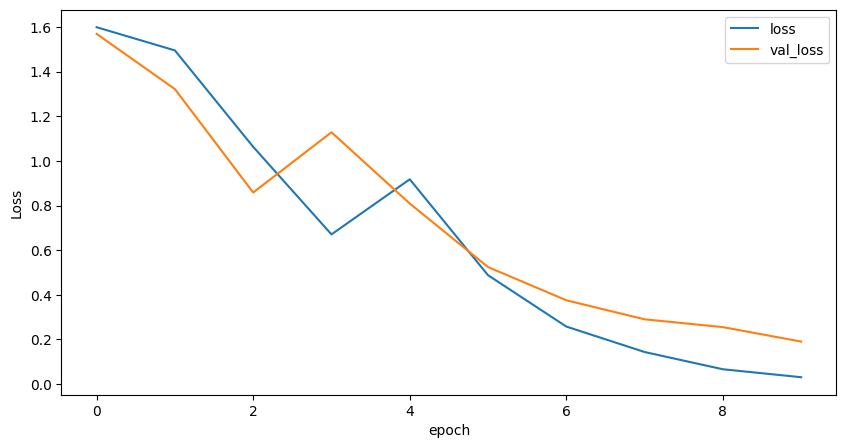

In [57]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [55]:
Y_predicted_LSTM = (model_LSTM.predict(X_test) >= 0.5).astype("int")

10/10 [==============================] - 2s 210ms/step


In [56]:
accuracy_score(Y_test, Y_predicted_LSTM)

0.9429530201342282

In [57]:
print(classification_report(Y_test, Y_predicted_LSTM))

              precision    recall  f1-score   support

           0       0.99      0.91      0.94        75
           1       0.88      0.98      0.93        46
           2       0.89      0.86      0.87        56
           3       0.98      1.00      0.99        63
           4       1.00      0.98      0.99        58

   micro avg       0.95      0.94      0.95       298
   macro avg       0.95      0.94      0.95       298
weighted avg       0.95      0.94      0.95       298
 samples avg       0.94      0.94      0.94       298



C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(95.72222222222221, 0.5, 'Actual')

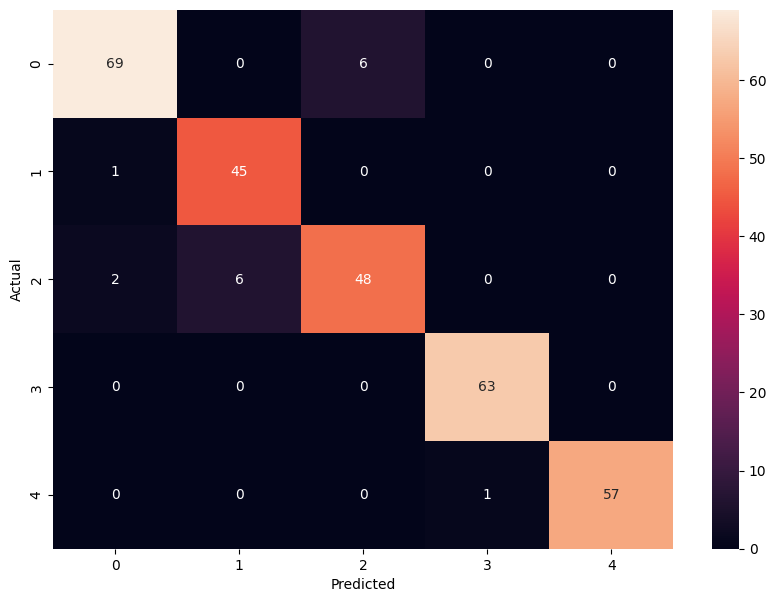

In [58]:
cm_LSTM = confusion_matrix(Y_test.argmax(axis=1), Y_predicted_LSTM.argmax(axis=1))
plt.figure(figsize=(10,7))
sns.heatmap(cm_LSTM, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Bi-Directional LSTM

In [62]:
model_Bi_LSTM = Sequential()
model_Bi_LSTM.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIMENSION, input_length=pad_sequence_X.shape[1]))
model_Bi_LSTM.add(SpatialDropout1D(0.3))
model_Bi_LSTM.add(Bidirectional(LSTM(EMBEDDING_DIMENSION, dropout=drop_lstm)))
model_Bi_LSTM.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model_Bi_LSTM.add(Dropout(drop_lstm))
model_Bi_LSTM.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model_Bi_LSTM.add(Dropout(drop_lstm))
model_Bi_LSTM.add(Dense(5, activation='softmax'))
model_Bi_LSTM.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode = min, patience=3, min_delta=0.0001)

2022-12-27 13:37:16,309 : WARNING : EarlyStopping mode <built-in function min> is unknown, fallback to auto mode.


In [63]:
from tensorflow.keras.utils import plot_model
print(model_Bi_LSTM.summary())
plot_model(model_Bi_LSTM, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         1000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1000, 100)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)              

In [64]:
history = model_Bi_LSTM.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=10, batch_size=16,validation_split=0.1,callbacks=[es])

Epoch 1/10
75/75 [==============================] - 94s 1s/step - loss: 1.5845 - accuracy: 0.2651 - val_loss: 1.5216 - val_accuracy: 0.3792
Epoch 2/10
75/75 [==============================] - 93s 1s/step - loss: 1.0048 - accuracy: 0.6174 - val_loss: 0.5806 - val_accuracy: 0.7718
Epoch 3/10
75/75 [==============================] - 92s 1s/step - loss: 0.3831 - accuracy: 0.8649 - val_loss: 0.5611 - val_accuracy: 0.8255
Epoch 4/10
75/75 [==============================] - 80s 1s/step - loss: 0.1436 - accuracy: 0.9497 - val_loss: 0.4868 - val_accuracy: 0.8591
Epoch 5/10
75/75 [==============================] - 85s 1s/step - loss: 0.0986 - accuracy: 0.9673 - val_loss: 0.5863 - val_accuracy: 0.8490
Epoch 6/10
75/75 [==============================] - 79s 1s/step - loss: 0.0404 - accuracy: 0.9883 - val_loss: 0.7811 - val_accuracy: 0.8121
Epoch 7/10
75/75 [==============================] - 75s 1s/step - loss: 0.0810 - accuracy: 0.9790 - val_loss: 0.7252 - val_accuracy: 0.8255


In [65]:
score = model_Bi_LSTM.evaluate(X_test, Y_test, verbose = 0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

Test loss: 0.7251617908477783
Test accuracy: 0.8255033493041992


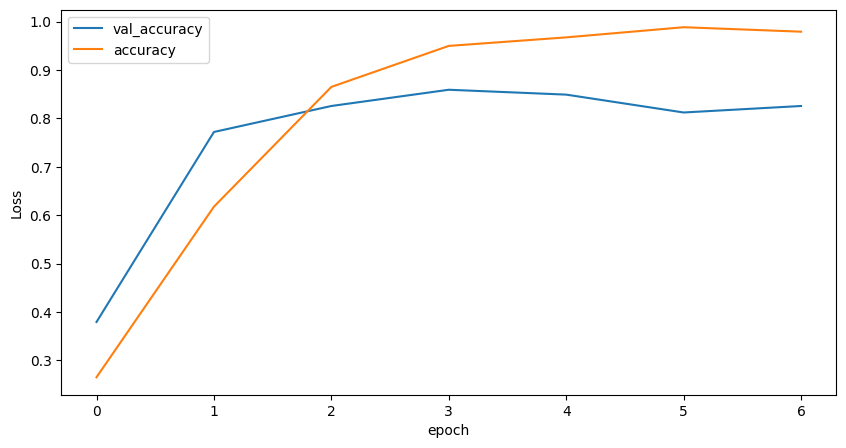

In [66]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

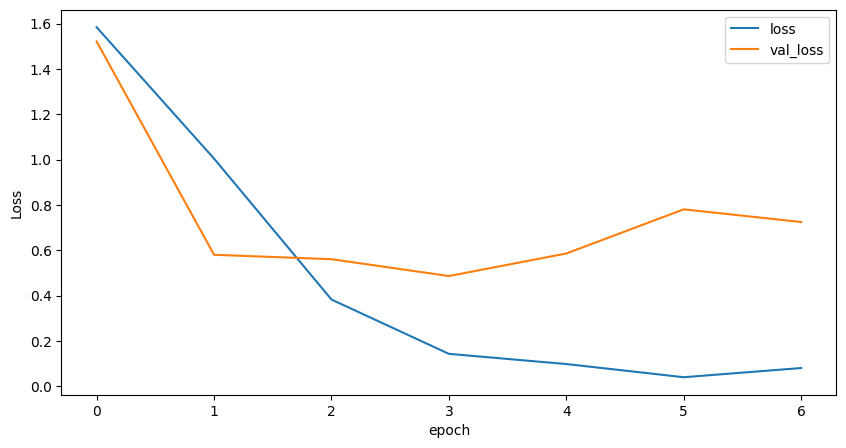

In [67]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [68]:
Y_predicted_Bi_LSTM = (model_Bi_LSTM.predict(X_test) >= 0.5).astype("int")

10/10 [==============================] - 6s 450ms/step


In [69]:
accuracy_score(Y_test, Y_predicted_Bi_LSTM)

0.825503355704698

Text(95.72222222222221, 0.5, 'Actual')

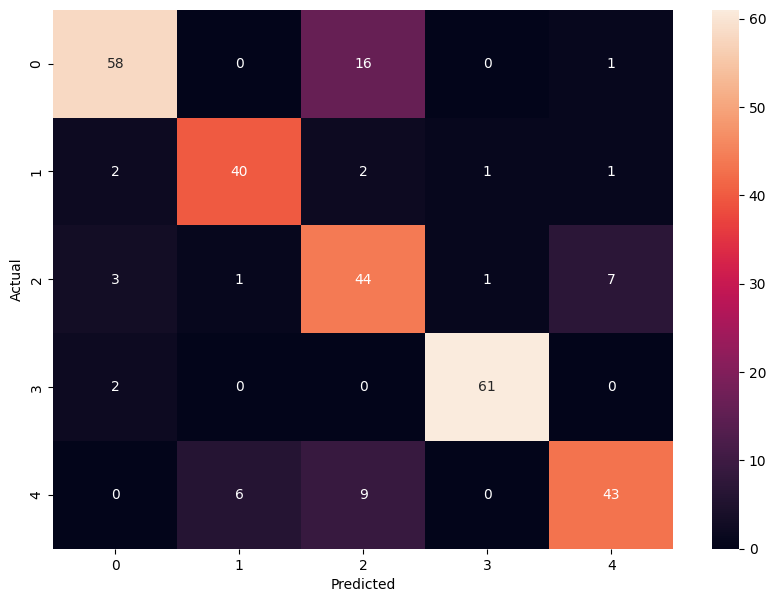

In [70]:
cm_Bi_LSTM = confusion_matrix(Y_test.argmax(axis=1), Y_predicted_Bi_LSTM.argmax(axis=1))
plt.figure(figsize=(10,7))
sns.heatmap(cm_Bi_LSTM, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

## GRU: Gated Recurrent Unit

In [71]:
model_GRU = Sequential()
model_GRU.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIMENSION, input_length=pad_sequence_X.shape[1]))
model_GRU.add(SpatialDropout1D(0.3))
model_GRU.add(GRU(EMBEDDING_DIMENSION, return_sequences = False))
model_GRU.add(Dropout(drop_lstm))
model_GRU.add(Dense(5, activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode = min, patience=3, min_delta=0.0001)

2022-12-27 13:50:33,223 : WARNING : EarlyStopping mode <built-in function min> is unknown, fallback to auto mode.


In [72]:
from tensorflow.keras.utils import plot_model
print(model_GRU.summary())
plot_model(model_GRU, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         1000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 1000, 100)        0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 505       
                                                                 
Total params: 1,061,105
Trainable params: 1,061,105
Non-trainable params: 0
____________________________________________

In [73]:
history = model_GRU.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=10, batch_size=16,validation_split=0.1,callbacks=[es])

Epoch 1/10
75/75 [==============================] - 59s 722ms/step - loss: 1.5910 - accuracy: 0.2768 - val_loss: 1.3713 - val_accuracy: 0.2517
Epoch 2/10
75/75 [==============================] - 52s 693ms/step - loss: 1.0255 - accuracy: 0.6267 - val_loss: 0.6449 - val_accuracy: 0.6879
Epoch 3/10
75/75 [==============================] - 52s 689ms/step - loss: 0.3427 - accuracy: 0.9027 - val_loss: 0.5072 - val_accuracy: 0.8054
Epoch 4/10
75/75 [==============================] - 69s 921ms/step - loss: 0.1373 - accuracy: 0.9589 - val_loss: 0.4876 - val_accuracy: 0.8356
Epoch 5/10
75/75 [==============================] - 71s 953ms/step - loss: 0.0816 - accuracy: 0.9832 - val_loss: 0.8089 - val_accuracy: 0.8020
Epoch 6/10
75/75 [==============================] - 73s 973ms/step - loss: 0.0582 - accuracy: 0.9824 - val_loss: 0.4764 - val_accuracy: 0.8523
Epoch 7/10
75/75 [==============================] - 53s 707ms/step - loss: 0.0185 - accuracy: 0.9958 - val_loss: 0.4893 - val_accuracy: 0.8591

In [74]:
score = model_GRU.evaluate(X_test, Y_test, verbose = 0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

Test loss: 0.5321795344352722
Test accuracy: 0.8657718300819397


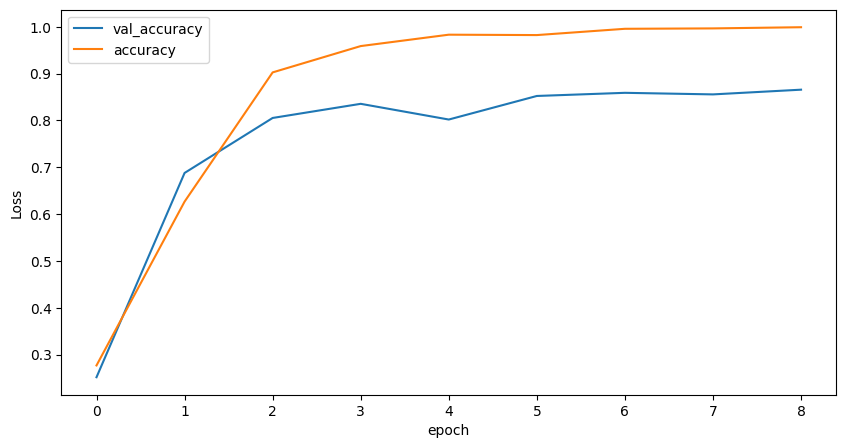

In [75]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

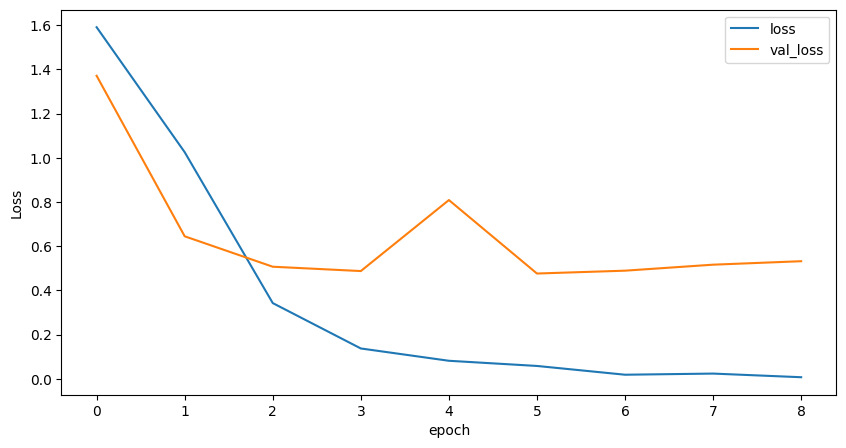

In [76]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [77]:
Y_predicted_GRU = (model_GRU.predict(X_test) >= 0.5).astype("int")

10/10 [==============================] - 4s 286ms/step


In [78]:
accuracy_score(Y_test, Y_predicted_GRU)

0.8657718120805369

In [79]:
print(classification_report(Y_test, Y_predicted_GRU))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89        75
           1       0.79      0.91      0.85        46
           2       0.73      0.84      0.78        56
           3       0.95      1.00      0.98        63
           4       0.93      0.74      0.83        58

   micro avg       0.87      0.87      0.87       298
   macro avg       0.87      0.87      0.86       298
weighted avg       0.88      0.87      0.87       298
 samples avg       0.87      0.87      0.87       298



C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(95.72222222222221, 0.5, 'Actual')

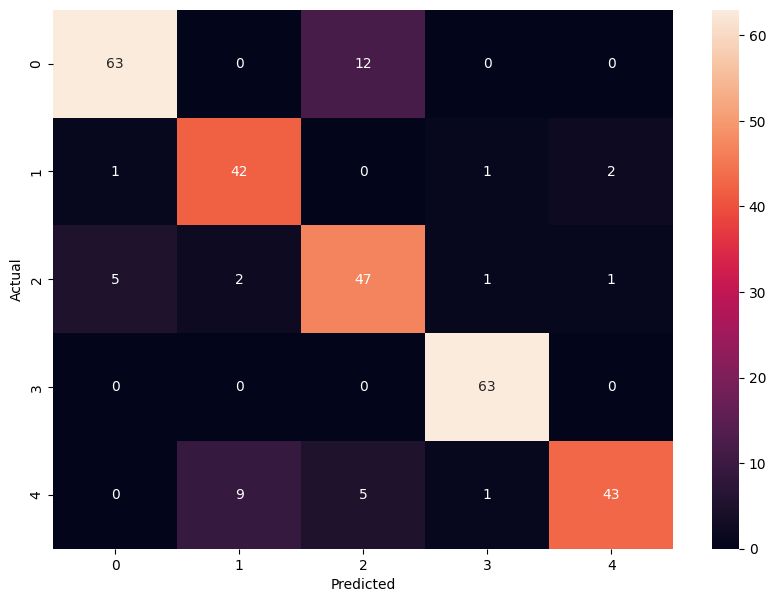

In [80]:
cm_GRU = confusion_matrix(Y_test.argmax(axis=1), Y_predicted_GRU.argmax(axis=1))
plt.figure(figsize=(10,7))
sns.heatmap(cm_GRU, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

## DL model pickle files

In [59]:
# serialize model to JSON
model_LSTM_json = model_LSTM.to_json()
with open("model_LSTM.json", "w") as json_file:
    json_file.write(model_LSTM_json)

In [60]:
# serialize weights to HDF5
model_LSTM.save_weights("model_LSTM.h5")
print("Saved model to disk")

Saved model to disk


In [85]:
# serialize model to JSON
model_Bi_LSTM_json = model_Bi_LSTM.to_json()
with open("model_bi_LSTM.json", "w") as json_file:
    json_file.write(model_Bi_LSTM_json)

In [86]:
# serialize weights to HDF5
model_Bi_LSTM.save_weights("model_Bi_LSTM.h5")
print("Saved model to disk")

Saved model to disk


In [87]:
# serialize model to JSON
model_GRU_json = model_GRU.to_json()
with open("model_GRU.json", "w") as json_file:
    json_file.write(model_GRU_json)

In [88]:
# serialize weights to HDF5
model_GRU.save_weights("model_GRU.h5")
print("Saved model to disk")

Saved model to disk


## Model Testing

In [91]:
import re
from bs4 import BeautifulSoup
import string
from nltk.stem import WordNetLemmatizer
label = sklearn.preprocessing.LabelEncoder()

def detect_catagory(model,sentence):

  sentence = re.sub(r"n\'t", " not", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'s", " is", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'t", " not", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'m", " am", sentence)
  sentence = re.sub(r"wont", "will not", sentence)
  sentence = re.sub(r"wouldnt", "would not", sentence)
  sentence = re.sub(r"shouldnt", "should not", sentence)
  sentence = re.sub(r"couldnt", "could not", sentence)
  sentence = re.sub(r"cudnt", "could not", sentence)
  sentence = re.sub(r"cant", "can not", sentence)
  sentence = re.sub(r"dont", "do not", sentence)
  sentence = re.sub(r"doesnt", "does not", sentence)
  sentence = re.sub(r"didnt", "did not", sentence)
  sentence = re.sub(r"wasnt", "was not", sentence)
  sentence = re.sub(r"werent", "were not", sentence)
  sentence = re.sub(r"havent", "have not", sentence)
  sentence = re.sub(r"hadnt", "had not", sentence)
  sentence = re.sub(r"ain't", "am not",sentence)
  sentence = re.sub(r"aren't", "are not",sentence)
  sentence = re.sub(r"can't", "cannot",sentence)
  sentence = re.sub(r"can't've", "cannot have",sentence)
  sentence = re.sub(r"'cause", "because",sentence)
  sentence = re.sub(r"could've", "could have",sentence)
  sentence = re.sub(r"couldn't", "could not",sentence)
  sentence = re.sub(r"couldn't've", "could not have",sentence)
  sentence = re.sub(r"didn't", "did not",sentence)
  sentence = re.sub(r"doesn't", "does not",sentence)
  sentence = re.sub(r"don't", "do not",sentence)
  sentence = re.sub(r"hadn't", "had not",sentence)
  sentence = re.sub(r"hadn't've", "had not have",sentence)
  sentence = re.sub(r"hasn't", "has not",sentence)
  sentence = re.sub(r"haven't", "have not",sentence)
  sentence = re.sub(r"he'd", "he would",sentence)
  sentence = re.sub(r"he'd've", "he would have",sentence)
  sentence = re.sub(r"he'll", "he will",sentence)
  sentence = re.sub(r"he'll've", "he will have",sentence)
  sentence = re.sub(r"he's", "he is",sentence)
  sentence = re.sub(r"how'd", "how did",sentence)
  sentence = re.sub(r"how'd'y", "how do you",sentence)
  sentence = re.sub(r"how'll", "how will",sentence)
  sentence = re.sub(r"how's", "how is",sentence)
  sentence = re.sub(r"i'd", "I would",sentence)
  sentence = re.sub(r"i'd've", "I would have",sentence)
  sentence = re.sub(r"i'll", "I will",sentence)
  sentence = re.sub(r"i'll've", "I will have",sentence)
  sentence = re.sub(r"i'm", "I am",sentence)
  sentence = re.sub(r"i've", "I have",sentence)
  sentence = re.sub(r"isn't", "is not",sentence)
  sentence = re.sub(r"it'd", "it had",sentence)
  sentence = re.sub(r"it'd've", "it would have",sentence)
  sentence = re.sub(r"it'll", "it will",sentence)
  sentence = re.sub(r"it'll've", "it will have",sentence)
  sentence = re.sub(r"it's", "it is",sentence)
  sentence = re.sub(r"let's", "let us",sentence)
  sentence = re.sub(r"ma'am", "madam",sentence)
  sentence = re.sub(r"mayn't", "may not",sentence)
  sentence = re.sub(r"might've", "might have",sentence)
  sentence = re.sub(r"mightn't", "might not",sentence)
  sentence = re.sub(r"mightn't've", "might not have",sentence)
  sentence = re.sub(r"must've", "must have",sentence)
  sentence = re.sub(r"mustn't", "must not",sentence)
  sentence = re.sub(r"mustn't've", "must not have",sentence)
  sentence = re.sub(r"needn't", "need not",sentence)
  sentence = re.sub(r"needn't've", "need not have",sentence)
  sentence = re.sub(r"o'clock", "of the clock",sentence)
  sentence = re.sub(r"oughtn't", "ought not",sentence)
  sentence = re.sub(r"oughtn't've", "ought not have",sentence)
  sentence = re.sub(r"shan't", "shall not",sentence)
  sentence = re.sub(r"sha'n't", "shall not",sentence)
  sentence = re.sub(r"shan't've", "shall not have",sentence)
  sentence = re.sub(r"she'd", "she would",sentence)
  sentence = re.sub(r"she'd've", "she would have",sentence)
  sentence = re.sub(r"she'll", "she will",sentence)
  sentence = re.sub(r"she'll've", "she will have",sentence)
  sentence = re.sub(r"she's", "she is",sentence)
  sentence = re.sub(r"should've", "should have",sentence)
  sentence = re.sub(r"shouldn't", "should not",sentence)
  sentence = re.sub(r"shouldn't've", "should not have",sentence)
  sentence = re.sub(r"so've", "so have",sentence)
  sentence = re.sub(r"so's", "so is",sentence)
  sentence = re.sub(r"that'd", "that would",sentence)
  sentence = re.sub(r"that'd've", "that would have",sentence)
  sentence = re.sub(r"that's", "that is",sentence)
  sentence = re.sub(r"there'd", "there had",sentence)
  sentence = re.sub(r"there'd've", "there would have",sentence)
  sentence = re.sub(r"there's", "there is",sentence)
  sentence = re.sub(r"they'd", "they would",sentence)
  sentence = re.sub(r"they'd've", "they would have",sentence)
  sentence = re.sub(r"they'll", "they will",sentence)
  sentence = re.sub(r"they'll've", "they will have",sentence)
  sentence = re.sub(r"they're", "they are",sentence)
  sentence = re.sub(r"they've", "they have",sentence)
  sentence = re.sub(r"to've", "to have",sentence)
  sentence = re.sub(r"wasn't", "was not",sentence)
  sentence = re.sub(r"we'd", "we had",sentence)
  sentence = re.sub(r"we'd've", "we would have",sentence)
  sentence = re.sub(r"we'll", "we will",sentence)
  sentence = re.sub(r"we'll've", "we will have",sentence)
  sentence = re.sub(r"we're", "we are",sentence)
  sentence = re.sub(r"we've", "we have",sentence)
  sentence = re.sub(r"weren't", "were not",sentence)
  sentence = re.sub(r"what'll", "what will",sentence)
  sentence = re.sub(r"what'll've", "what will have",sentence)
  sentence = re.sub(r"what're", "what are",sentence)
  sentence = re.sub(r"what's", "what is",sentence)
  sentence = re.sub(r"what've", "what have",sentence)
  sentence = re.sub(r"when's", "when is",sentence)
  sentence = re.sub(r"when've", "when have",sentence)
  sentence = re.sub(r"where'd", "where did",sentence)
  sentence = re.sub(r"where's", "where is",sentence)
  sentence = re.sub(r"where've", "where have",sentence)
  sentence = re.sub(r"who'll", "who will",sentence)
  sentence = re.sub(r"who'll've", "who will have",sentence)
  sentence = re.sub(r"who's", "who is",sentence)
  sentence = re.sub(r"who've", "who have",sentence)
  sentence = re.sub(r"why's", "why is",sentence)
  sentence = re.sub(r"why've", "why have",sentence)
  sentence = re.sub(r"will've", "will have",sentence)
  sentence = re.sub(r"won't", "will not",sentence)
  sentence = re.sub(r"won't've", "will not have",sentence)
  sentence = re.sub(r"would've", "would have",sentence)
  sentence = re.sub(r"wouldn't", "would not",sentence)
  sentence = re.sub(r"wouldn't've", "would not have",sentence)
  sentence = re.sub(r"y'all", "you all",sentence)
  sentence = re.sub(r"y'alls", "you alls",sentence)
  sentence = re.sub(r"y'all'd", "you all would",sentence)
  sentence = re.sub(r"y'all'd've", "you all would have",sentence)
  sentence = re.sub(r"y'all're", "you all are",sentence)
  sentence = re.sub(r"y'all've", "you all have",sentence)
  sentence = re.sub(r"you'd", "you had",sentence)
  sentence = re.sub(r"you'd've", "you would have",sentence)
  sentence = re.sub(r"you'll", "you you will",sentence)
  sentence = re.sub(r"you'll've", "you you will have",sentence)
  sentence = re.sub(r"you're", "you are",sentence)
  sentence = re.sub(r"you've", "you have",sentence)

  
  sentence = re.sub(r'[^\w\s]','',sentence) # Remove Punctutation
  
  sentence = sentence.lower() # Lower case
  
  CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  sentence = re.sub(CLEANR, '', sentence)# Remove HTML
  
  sentence = re.sub('[^A-Za-z]',' ',sentence)# Remove Digits
 
  sentence = re.sub(r'[\w._%+-]{1,20}@[\w.-]{1,20}.[A-Za-z]{2,3}','', sentence)# Remove Email
  
  sentence = re.sub(r'^http?s:\/\/.*[\r\n]*','', sentence)# Remove URLs
  
  sentence = re.sub(r'@[A-Za-z0-9]+','',sentence) #Remove Mentions  

  sentence = " ".join(item for item in sentence.split() if item not in stopwords.words('english') )
  
  sentence = ' '.join([PorterStemmer().stem(word)for word in sentence.split()])

  sentence = ' '.join([WordNetLemmatizer().lemmatize(word) for word in sentence.split()])
    
  #return sentence
  return label_fit.inverse_transform(model.predict(TFIDF_vector.transform([sentence])))[0]

In [100]:
article = """
Harman footballer for some but an emotion for many completed football by winning the FIFA World Cup title which
"""

In [101]:
detect_catagory(model_BNB, article)

'sport'

In [102]:
detect_catagory(model_CNB, article)

'sport'

In [103]:
detect_catagory(model_MNB, article)

'sport'

In [105]:
detect_catagory(model_SGD, article)

'sport'